```!python3 -m spacy download en_core_web_lg```

In [9]:
import spacy
import pandas as pd
import numpy as np
import nltk
import time
from tqdm import tqdm
import operator
from fuzzywuzzy import fuzz
import datetime
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# eng = spacy.load('en_core_web_lg')

In [10]:
# load scraped articles
df1 = pd.read_csv('Data/30B113K_scraped_0Kto50K.csv', sep=';', encoding='utf-8', parse_dates=['publish_date'])
df2 = pd.read_csv('Data/30B113K_scraped_50KtoEnd.csv', sep=';', encoding='utf-8', parse_dates=['publish_date'])
df = df1.append(df2)

In [11]:
len(df)

62248

In [11]:
# optional sample
df = df.sample(1000).reset_index(drop=True)

## Preprocessing

In [12]:
# add mediabias to scraped articles
bias = pd.read_csv('Data/mediacloud30bias.csv', sep=';', encoding='utf-8')
df['mix_rating'] = None
for i, media in enumerate(df.media_name):
    for j, media2 in enumerate(bias.media_name):
        if media == media2:
            df['mix_rating'].iloc[i] = bias.mix_rating.iloc[j]

In [13]:
# check random article
s = df.sample(1).iloc[0]
print('media: '+ str(s[0]))
print('title: ' + s[1])
print('date: ' + str(s[5]))
print('url: ' + str(s[3]))
print('text: ' + str(s[2]))

media: Business Insider
title: NRA leadership thought its own TV channel was airing 'distasteful and racist' content
date: 28.10.19 14:22
url: http://feedproxy.google.com/~r/businessinsider/~3/4fVlBq6L8uY/nra-leaders-found-nratv-to-be-distasteful-and-racist-2019-10
text: NRA leaders ripped into NRATV content as "distasteful and racist" in a new court filing linked to a lawsuit with the ad firm that created the now-defunct TV station.

"One particularly damaging segment featured children's cartoon characters adorned in Ku Klux Klan hoods," the court filing stated.

"Tellingly, when NRATV finally shut down in June 2019, no one missed it," the NRA states in the filing.

The ad firm rejected the NRA's allegations as "false claims" and slammed its leadership, stating they are now groveling "at the feet of the media they used to decry."

The lawsuit comes amid a year of bad headlines for the NRA, including reports of infighting between leaders as well as serious financial troubles.

Visit Bu

In [13]:
# remove missings and duplicate texts
len1 = len(df)
df = df[(df.text.isnull() == False) & 
        (df.publish_date.isnull() == False) & 
        (df.title.isnull() == False) &
        (df.mix_rating.isnull() == False)]
len2 = len(df)
print('Missings: removed %i of %i articles' % (len1-len2,len1))

df = df.drop_duplicates(subset='text', keep="first")

len3 = len(df)
print('Duplicate texts: removed %i of %i articles' % (len2-len3,len2))

Missings: removed 11300 of 62248 articles
Duplicate texts: removed 7321 of 50948 articles


In [14]:
# convert dates
df['datetime'] =  pd.to_datetime(df['publish_date'], dayfirst=True, errors='coerce')

# convert to date
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.strftime('%Y')

# drop all outside daterange
start = datetime.datetime.strptime('2012-01-01', "%Y-%m-%d").date()
end = datetime.datetime.strptime('2019-12-31', "%Y-%m-%d").date()
drange = (df['date'] >= start) & (df['date'] <= end)
df = df.loc[drange]

## Descriptive

In [25]:
# check with which string the articles matched
gun_control_art = df[(df.text.str.contains('gun control')) & (df.media_name != 'Forbes')].groupby(['media_name', 'mix_rating'])[['title']].count().sort_values(by='mix_rating')
gun_rights_art = df[(df.text.str.contains('gun rights')) & (df.media_name != 'Forbes')].groupby(['media_name', 'mix_rating'])[['title']].count()
gun_laws_art = df[(df.text.str.contains('gun laws')) & (df.media_name != 'Forbes')].groupby(['media_name', 'mix_rating'])[['title']].count()
all_art = df[(df.media_name != 'Forbes')].groupby(['media_name', 'mix_rating'])[['title']].count()

mediacloud_match_string = pd.concat([all_art, gun_control_art, gun_rights_art, gun_laws_art], axis=1)
mediacloud_match_string.columns = ['Total', 'Gun Control', 'Gun Rights', 'Gun Laws']
mediacloud_match_string['Gun Control'] = round((mediacloud_match_string['Gun Control'] / mediacloud_match_string['Total']) * 100,1)
mediacloud_match_string['Gun Rights'] = round((mediacloud_match_string['Gun Rights'] / mediacloud_match_string['Total']) * 100,1)
mediacloud_match_string['Gun Laws'] = round((mediacloud_match_string['Gun Laws'] / mediacloud_match_string['Total']) * 100,1)

mediacloud_match_string = mediacloud_match_string.sort_values(by=['mix_rating', 'Total'], ascending=False)
mediacloud_match_string

,,Total,Gun Control,Gun Rights,Gun Laws
media_name,mix_rating,,,,
Washington Times,right,80,52.5,23.8,31.2
Breitbart,right,72,76.4,13.9,11.1
FOX News,right,41,48.8,24.4,26.8
Daily Caller,right,40,50.0,10.0,32.5
National Review,right,19,31.6,36.8,26.3
NY Post,right,17,47.1,NaN,35.3
NewsMax,right,17,47.1,35.3,23.5
The Blaze,right,8,75.0,NaN,NaN
thefederalist.com,right,3,66.7,33.3,NaN


In [16]:
# no of words per article
def WordCounter(text):
    return len(text.split(' '))

df['no_words'] = df.text.apply(lambda x: WordCounter(x))

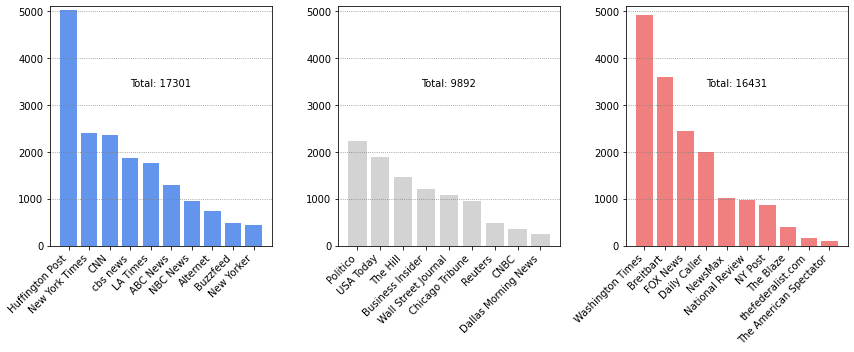

In [21]:
# number of articles per medium
left_media = df[df.mix_rating == 'left'].groupby('media_name')[['title', 'mix_rating', 'no_words']].agg({'title': 'count', 'mix_rating': 'count', 'no_words': 'mean'}).sort_values('title', ascending=False)
center_media = df[(df.mix_rating == 'center') & (df.media_name != 'Forbes')].groupby('media_name')[['title', 'mix_rating', 'no_words']].agg({'title': 'count', 'mix_rating': 'count', 'no_words': 'mean'}).sort_values('title', ascending=False)
right_media = df[df.mix_rating == 'right'].groupby('media_name')[['title', 'mix_rating', 'no_words']].agg({'title': 'count', 'mix_rating': 'count', 'no_words': 'mean'}).sort_values('title', ascending=False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
colors=['cornflowerblue', 'lightgrey', 'lightcoral']

ax[0].bar(left_media.index, left_media.title, color=colors[0])
ax[0].set_xticklabels(left_media.index, rotation=45, ha='right')
ax[0].set_ylim([0,5100])
ax[0].grid(b=True, axis='y', which='major', color='grey', linestyle='dotted')

#ax0 = ax[0].twinx()
#ax0.plot(left_media.no_words, color='grey')
#ax0.set_ylim([0,2000])

left_total = 'Total: ' + str(sum(left_media.title))
ax[0].text(0.5, 0.68, left_total, horizontalalignment='center',
           verticalalignment='center', transform=ax[0].transAxes)

ax[1].bar(center_media.index, center_media.title, color=colors[1])
ax[1].set_xticklabels(center_media.index, rotation=45, ha='right')
ax[1].set_ylim([0,5100])
ax[1].grid(b=True, axis='y', which='major', color='grey', linestyle='dotted')

#ax1 = ax[1].twinx()
#ax1.plot(center_media.no_words, color='grey')
#ax1.set_ylim([0,2000])

center_total = 'Total: ' + str(sum(center_media.title))
ax[1].text(0.5, 0.68, center_total, horizontalalignment='center',
           verticalalignment='center', transform=ax[1].transAxes)


ax[2].bar(right_media.index, right_media.title, color=colors[2])
ax[2].set_xticklabels(right_media.index, rotation=45, ha='right')
ax[2].set_ylim([0,5100])
ax[2].grid(b=True, axis='y', which='major', color='grey', linestyle='dotted')

#ax2 = ax[2].twinx()
#ax2.plot(right_media.no_words, color='grey')
#ax2.set_ylim([0,2000])

right_total = 'Total: ' + str(sum(right_media.title))
ax[2].text(0.5, 0.68, right_total, horizontalalignment='center',
           verticalalignment='center', transform=ax[2].transAxes)

fig.tight_layout()
plt.savefig('Graphs/number_articles.png')

## NER

In [113]:
# fullname matcher
def FullnameMatcher(name, people):
    matches = {}
    person_len = len(name.split(' '))
    if person_len == 1:     
        #print('SHORT: ' + name)
        for person2 in people.keys():

            person2_len = len(person2.split(' '))        

            if person_len < person2_len:

                if fuzz.ratio(name, person2) > 60:
                    # print('MATCH WITH: ' + person2)
                    matches[person2] = people.get(person2)

        try:
            name = max(matches.items(), key=operator.itemgetter(1))[0]
        except ValueError as E:
            name = name
    return name

In [114]:
# function to identify people in article
def NERPeople(text):
    people = {}
    for ent in eng(text).ents:
        if ent.label_ == 'PERSON':
            # clean the name string
            person = str(ent).replace("'s", '').encode("ascii", "ignore").decode()
            person = FullnameMatcher(person, people)
            
            people[person] = people.get(person, 0) + 1           

    return people

In [123]:
chunks = np.array_split(df, 100)

43627

In [126]:
# NER in chunks
for i, chunk in tqdm(enumerate(chunks)):
    print('Processing chunk '+str(i+1))
    chunk['people'] = chunk.text.apply(lambda x: NERPeople(x))
    path = 'Data/Chunks/v_'+str(i)+'.csv'
    chunk.to_csv(path, sep=';', encoding='utf-8', index=False)






0it [00:00, ?it/s]

Processing chunk 1







1it [00:44, 44.54s/it]

Processing chunk 2







2it [01:12, 39.43s/it]

Processing chunk 3







3it [01:43, 36.90s/it]

Processing chunk 4







4it [02:13, 34.93s/it]

Processing chunk 5







5it [02:50, 35.50s/it]

Processing chunk 6







6it [03:23, 34.84s/it]

Processing chunk 7







7it [03:56, 34.42s/it]

Processing chunk 8







8it [04:30, 34.11s/it]

Processing chunk 9







9it [05:05, 34.40s/it]

Processing chunk 10







10it [05:33, 32.57s/it]

Processing chunk 11







11it [06:10, 33.81s/it]

Processing chunk 12







12it [06:46, 34.64s/it]

Processing chunk 13







13it [07:23, 35.20s/it]

Processing chunk 14







14it [08:00, 35.76s/it]

Processing chunk 15







15it [08:40, 36.92s/it]

Processing chunk 16







16it [09:18, 37.21s/it]

Processing chunk 17







17it [09:54, 36.97s/it]

Processing chunk 18







18it [10:27, 35.81s/it]

Processing chunk 19







19it [11:02, 35.68s/it]

Processing chunk 20







20it [11:45, 37.65s/it]

Processing chunk 21







21it [12:22, 37.67s/it]

Processing chunk 22







22it [13:01, 37.98s/it]

Processing chunk 23







23it [13:41, 38.55s/it]

Processing chunk 24







24it [14:24, 39.81s/it]

Processing chunk 25







25it [14:56, 37.47s/it]

Processing chunk 26







26it [15:38, 38.84s/it]

Processing chunk 27







27it [16:22, 40.35s/it]

Processing chunk 28







28it [17:02, 40.45s/it]

Processing chunk 29







29it [17:55, 44.13s/it]

Processing chunk 30







30it [18:38, 43.74s/it]

Processing chunk 31







31it [19:17, 42.47s/it]

Processing chunk 32







32it [19:53, 40.41s/it]

Processing chunk 33







33it [20:24, 37.65s/it]

Processing chunk 34







34it [21:10, 39.97s/it]

Processing chunk 35







35it [21:54, 41.26s/it]

Processing chunk 36







36it [22:23, 37.77s/it]

Processing chunk 37







37it [22:57, 36.44s/it]

Processing chunk 38







38it [23:39, 38.24s/it]

Processing chunk 39







39it [24:16, 37.65s/it]

Processing chunk 40







40it [24:55, 38.07s/it]

Processing chunk 41







41it [25:42, 40.96s/it]

Processing chunk 42







42it [26:28, 42.47s/it]

Processing chunk 43







43it [27:07, 41.26s/it]

Processing chunk 44







44it [27:41, 39.20s/it]

Processing chunk 45







45it [28:23, 39.99s/it]

Processing chunk 46







46it [29:05, 40.49s/it]

Processing chunk 47







47it [29:46, 40.79s/it]

Processing chunk 48







48it [30:32, 42.23s/it]

Processing chunk 49







49it [31:17, 43.24s/it]

Processing chunk 50







50it [31:53, 40.92s/it]

Processing chunk 51







51it [32:26, 38.75s/it]

Processing chunk 52







52it [33:12, 40.93s/it]

Processing chunk 53







53it [33:56, 41.71s/it]

Processing chunk 54







54it [34:37, 41.41s/it]

Processing chunk 55







55it [35:13, 39.87s/it]

Processing chunk 56







56it [35:49, 38.79s/it]

Processing chunk 57







57it [36:40, 42.34s/it]

Processing chunk 58







58it [37:25, 43.11s/it]

Processing chunk 59







59it [38:01, 41.02s/it]

Processing chunk 60







60it [38:42, 40.98s/it]

Processing chunk 61







61it [39:23, 41.00s/it]

Processing chunk 62







62it [40:09, 42.53s/it]

Processing chunk 63







63it [40:54, 43.33s/it]

Processing chunk 64







64it [41:37, 43.27s/it]

Processing chunk 65







65it [42:24, 44.42s/it]

Processing chunk 66







66it [43:14, 46.02s/it]

Processing chunk 67







67it [44:07, 48.06s/it]

Processing chunk 68







68it [44:50, 46.51s/it]

Processing chunk 69







69it [45:41, 47.86s/it]

Processing chunk 70







70it [46:33, 49.04s/it]

Processing chunk 71







71it [47:28, 50.96s/it]

Processing chunk 72







72it [48:19, 50.88s/it]

Processing chunk 73







73it [49:34, 58.14s/it]

Processing chunk 74







74it [50:42, 61.26s/it]

Processing chunk 75







75it [51:28, 56.43s/it]

Processing chunk 76







76it [52:19, 55.05s/it]

Processing chunk 77







77it [53:04, 51.98s/it]

Processing chunk 78







78it [53:47, 49.14s/it]

Processing chunk 79







79it [54:38, 49.72s/it]

Processing chunk 80







80it [55:28, 49.96s/it]

Processing chunk 81







81it [56:06, 46.19s/it]

Processing chunk 82







82it [56:54, 46.82s/it]

Processing chunk 83







83it [57:37, 45.78s/it]

Processing chunk 84







84it [58:30, 47.94s/it]

Processing chunk 85







85it [59:08, 44.90s/it]

Processing chunk 86







86it [59:55, 45.48s/it]

Processing chunk 87







87it [1:00:36, 44.09s/it]

Processing chunk 88







88it [1:01:21, 44.38s/it]

Processing chunk 89







89it [1:02:15, 47.40s/it]

Processing chunk 90







90it [1:03:07, 48.66s/it]

Processing chunk 91







91it [1:03:54, 48.18s/it]

Processing chunk 92







92it [1:04:57, 52.75s/it]

Processing chunk 93







93it [1:05:42, 50.41s/it]

Processing chunk 94







94it [1:06:37, 51.78s/it]

Processing chunk 95







95it [1:07:23, 49.94s/it]

Processing chunk 96







96it [1:08:08, 48.52s/it]

Processing chunk 97







97it [1:08:54, 47.59s/it]

Processing chunk 98







98it [1:09:38, 46.59s/it]

Processing chunk 99







99it [1:10:41, 51.44s/it]

Processing chunk 100







100it [1:11:38, 42.98s/it]
